In [84]:
%matplotlib inline
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import altair as alt

alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype');

import os
import pickle

from copy import deepcopy
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso, LinearRegression, Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

np.random.seed(42)
from itertools import product

In [85]:
from data_processing import process_data

REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

prod = pd.read_csv('palm_oil_data/production_good.csv')
rain = pd.read_csv('palm_oil_data/rainfall_good.csv')
area = pd.read_csv('palm_oil_data/area_good.csv')
RAINFALL_LAGS = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
PRODUCTION_LAGS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
DATA = process_data(prod, rain, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
X = DATA['Johor'][0]
Y = DATA['Johor'][1]
X.columns

Index(['Johor_Month', 'Johor_Production', 'Johor_Rainfall', 'Johor_Area_ma',
       'Johor_Area_npa', 'Johor_Area_rpa', 'Johor_Area_ma_new', 'Johor_Time',
       'Johor_Rainfall_13', 'Johor_Rainfall_14', 'Johor_Rainfall_15',
       'Johor_Rainfall_16', 'Johor_Rainfall_17', 'Johor_Rainfall_18',
       'Johor_Rainfall_19', 'Johor_Rainfall_20', 'Johor_Rainfall_21',
       'Johor_Rainfall_22', 'Johor_Rainfall_23', 'Johor_Rainfall_24',
       'Johor_Rainfall_25', 'Johor_Rainfall_26', 'Johor_Production_1',
       'Johor_Production_2', 'Johor_Production_3', 'Johor_Production_4',
       'Johor_Production_5', 'Johor_Production_6', 'Johor_Production_7',
       'Johor_Production_8', 'Johor_Production_9', 'Johor_Production_10',
       'Johor_Production_11', 'Johor_Production_12', 'Johor_Production_13'],
      dtype='object')

## Feature Analysis

In [86]:
X["dt"] = X.index
X.head()


,Johor_Month,Johor_Production,Johor_Rainfall,Johor_Area_ma,Johor_Area_npa,Johor_Area_rpa,Johor_Area_ma_new,Johor_Time,Johor_Rainfall_13,Johor_Rainfall_14,...,Johor_Production_5,Johor_Production_6,Johor_Production_7,Johor_Production_8,Johor_Production_9,Johor_Production_10,Johor_Production_11,Johor_Production_12,Johor_Production_13,dt
1999-02-01,2,147.240,50.775,574.0,613.0,7.0,403.330769,13,190.900,195.163756,...,210.113,195.686,182.535,163.215,155.827,154.638,145.514,147.988,118.359,1999-02-01
1999-03-01,3,169.754,281.750,574.0,613.0,7.0,403.330769,14,59.050,190.900000,...,203.115,210.113,195.686,182.535,163.215,155.827,154.638,145.514,147.988,1999-03-01
1999-04-01,4,192.155,144.150,574.0,613.0,7.0,403.330769,15,124.775,59.050000,...,186.055,203.115,210.113,195.686,182.535,163.215,155.827,154.638,145.514,1999-04-01
1999-05-01,5,216.570,159.600,574.0,613.0,7.0,403.330769,16,124.025,124.775000,...,158.304,186.055,203.115,210.113,195.686,182.535,163.215,155.827,154.638,1999-05-01
1999-06-01,6,210.553,101.925,574.0,613.0,7.0,403.330769,17,225.725,124.025000,...,133.109,158.304,186.055,203.115,210.113,195.686,182.535,163.215,155.827,1999-06-01


In [87]:
cols = ['Johor_Area_ma', 'Johor_Area_npa', 'Johor_Area_rpa', 'Johor_Area_ma_new', 'dt', 'Johor_Production', 'Johor_Rainfall']
alt.Chart(pd.melt(X[cols], "dt")).mark_line() \
.encode(
    x = alt.X("dt:T", axis=alt.Axis(format="%b %y")),
    y = alt.Y("value:Q")
).properties(width=800 / 2, height=800 / 4) \
.facet(
    facet=alt.Facet("variable:N"),
    columns=2
).resolve_scale(y="independent", x="independent")

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [88]:
from correlation_analysis import get_feature_importance_df, get_random_forest_importances, print_corr_anal, plot_correlations, part_autocorrelation
plot_correlations(X[cols])


<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [89]:
print_corr_anal(X[cols], n_lags=30)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [90]:
part_autocorrelation(X[cols])

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


#### I would take only rainfall numbers, because only them are good enough to predict for distant future (12 months). Area correlates well on the next or few next months

In [91]:
def process_data(production, rainfall, area, region, PRODUCTION_LAGS, RAINFALL_LAGS):
    data = production[production.Region == region[0]]
    data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                    rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                    on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[area.Region == region[2]][
        ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')

    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                   inplace=True)

    data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
    data['Time'] = np.arange(len(data))

    for lag in RAINFALL_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
        data['Rainfall_{0}'.format(lag)] = temp

    for lag in PRODUCTION_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
        data['Production_{0}'.format(lag)] = temp

    PRODUCTION = data.Production
    data.drop(['Production'], axis=1, inplace=True)

    data.fillna(data.mean(), inplace=True)

    #  And finally drop rainfalls
    data.drop(['Rainfall'], axis=1, inplace=True)

    return data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):]


PRODUCTION_LAGS = [1, 15]
RAINFALL_LAGS = [12, 35]

REGION = ['JH', 'Johor', 'JH']


In [92]:
# WMAPE metric
def wmape(y, y_hat):
    return np.abs((y - y_hat)).sum() / y.sum()
# RMSE metric
def rmse(y, y_hat):
    return np.sqrt(((y - y_hat) ** 2).mean())

In [93]:
def get_lag_subset(df, rainfall_lags, production_lags): # Rainfall_17', 'Production_1
    columns = [f"Production_{lag}" for lag in range(1, production_lags + 1)] + \
              [f"Rainfall_{lag + 12}" for lag in range(rainfall_lags + 1)]
    return df[columns]

def folds_iterator(n_folds, samples_per_fold, size):
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [94]:
# own k-validator
def validate_model(model, x, y, params, cv):
    model.set_params(**{param: param_value for param, param_value in params})
    rmse_sum, wmape_sum, count = 0, 0, 0
    for train_indices, test_indices in cv:
        x_train, y_train, x_test, y_test = x.iloc[train_indices], y.iloc[train_indices], x.iloc[test_indices], y.iloc[test_indices] 
        model.fit(x_train, y_train)
        y_hat = model.predict(x_test)
        rmse_sum += rmse(y_test, y_hat)
        wmape_sum += wmape(y_test, y_hat)
        count += 1
    
    return model, rmse_sum / count, wmape_sum / count

In [95]:
def validate_params(model, x, y, params, n_folds, samples_per_fold): # todo rewrite better
    best_model = None
    best_rmse, best_wmape = -np.Inf, -np.Inf
    best_params = {key: None for key in params}

    # idk how to handle this well
    if not params:
        return *validate_model(deepcopy(model), x, y, [], folds_iterator(n_folds, samples_per_fold, samples - test_set_size)), {}

    for cur_params in product(*(params.values())):
        # some combination of parameters
        cur_model, cur_rmse, cur_wmape = validate_model(deepcopy(model), x, y, zip(params.keys(), cur_params), folds_iterator(n_folds, samples_per_fold, samples - test_set_size))
        
        if abs(cur_rmse) < abs(best_rmse):
            best_rmse = cur_rmse
            best_wmape = cur_wmape
            best_model = cur_model
            for param, param_value in zip(params.keys(), cur_params):
                best_params[param] = param_value
    
    # return best
    return best_model, best_rmse, best_wmape, best_params

In [96]:
def validate_lags(model, params, train_set_size, n_folds, samples_per_fold):
    best_model = None
    best_rmse, best_wmape = -np.Inf, -np.Inf
    best_params = None
    best_prod_lags, best_rain_lags = [PRODUCTION_LAGS[0], None], [RAINFALL_LAGS[0], None]
        
    for prod_lag_end in range(*PRODUCTION_LAGS):
        for rain_lag_end in range(*RAINFALL_LAGS):
            x, y = process_data(prod, rain, area, REGION, range(PRODUCTION_LAGS[0], prod_lag_end + 1), range(RAINFALL_LAGS[0], rain_lag_end + 1))
            cur_model, cur_rmse, cur_wmape, cur_params = validate_params(deepcopy(model), x[:train_set_size], y[:train_set_size], params, n_folds, samples_per_fold)

            if abs(cur_rmse) < abs(best_rmse):
                best_rmse = cur_rmse
                best_wmape = cur_wmape
                best_model = cur_model
                best_params = cur_params
                best_prod_lags[1] = prod_lag_end
                best_rain_lags[1] = rain_lag_end
    
    print(f"Best lags number:\nProduction: {best_prod_lags}\nRainfall: {best_rain_lags}")
    
    print("\nBest hyper-parameters")
    for param_name in best_params:
        print(f"{param_name}: {best_params[param_name]}")

    print(f"\nRMSE: {best_rmse}; WMAPE: {best_wmape}")
    
    return best_model

In [97]:
samples = process_data(prod, rain, area, REGION, list(range(*PRODUCTION_LAGS)), list(range(*RAINFALL_LAGS)))[0].shape[0]
test_set_size = 12

n_folds = 5
samples_per_fold = test_set_size

rainfall_lags = 37
production_lags = 13


In [44]:
linear_regression = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", LinearRegression())]), 
                                  params={},
                                  train_set_size=-test_set_size,
                                  n_folds=n_folds,
                                  samples_per_fold=samples_per_fold)

Best lags number:
Production: [1, 8]
Rainfall: [12, 34]

Best hyper-parameters

RMSE: 21.991628919102972; WMAPE: 0.07242298472322227


In [45]:
ridge = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", Ridge(random_state=42))]), 
                    #   x=x_train,
                    #   y=y_train,
                      params={"reg__alpha": [0.01, 0.1, 1, 10]},
                      n_folds=n_folds,
                      train_set_size=-test_set_size,
                      samples_per_fold=samples_per_fold)


Best lags number:
Production: [1, 12]
Rainfall: [12, 34]

Best hyper-parameters
reg__alpha: 10

RMSE: 20.573433222610454; WMAPE: 0.07025330720393635


In [17]:
svr = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", SVR())]), 
                #     x=x_train,
                #     y=y_train,
                    params={"reg__C": [0.01, 0.1, 1, 10],
                            "reg__kernel": ["rbf", "linear"]},
                    n_folds=n_folds,
                    train_set_size=-test_set_size,

                    samples_per_fold=samples_per_fold)


Best lags number:
Production: [1, 12]
Rainfall: [12, 33]

Best hyper-parameters
reg__C: 10
reg__kernel: linear

RMSE: 20.076029546522008; WMAPE: 0.06701320041845805


In [49]:
random_forest = validate_lags(model=RandomForestRegressor(random_state=42),
                        #       x=x_train,
                        #       y=y_train,
                              train_set_size=-test_set_size,
                              params={"max_depth": [5],
                                      "min_samples_split": [6],
                                      "n_estimators": [200],
                                      "max_features": [0.6]},
                              n_folds=n_folds,
                              samples_per_fold=samples_per_fold)

Best lags number:
Production: [1, 14]
Rainfall: [12, 18]

Best hyper-parameters
max_depth: 5
min_samples_split: 6
n_estimators: 200
max_features: 0.6

RMSE: 20.762626413225597; WMAPE: 0.06903860559474675


### The best model here is SVR with Production: [1, 12] and Rainfall: [12, 33], so let's train it, and test on the last year:

In [98]:
X, y = process_data(prod, rain, area, REGION, range(PRODUCTION_LAGS[0], 12 + 1), range(RAINFALL_LAGS[0], 33 + 1))
x_train, y_train = x[:train_set_size], y[:train_set_size]
x_test, y_test = x[-test_set_size:], y[-test_set_size:]


In [99]:
y_hat = svr.predict(x_test)
wmape_score = wmape(y_test, y_hat)
rmse_score = rmse(y_test, y_hat)

predictions_df = pd.DataFrame({"dt": x_test.index, "Production": y_test, "forcasted sales": y_hat})
predictions_df

,dt,Production,forcasted sales
2016-10-01,2016-10-01,284.922,332.489823
2016-11-01,2016-11-01,274.107,306.989157
2016-12-01,2016-12-01,254.881,262.172019
2017-01-01,2017-01-01,211.810,270.506950
2017-02-01,2017-02-01,214.747,250.178913
2017-03-01,2017-03-01,210.002,251.995355
2017-04-01,2017-04-01,216.574,264.056989
2017-05-01,2017-05-01,225.834,268.615735
2017-06-01,2017-06-01,205.989,259.325360
2017-07-01,2017-07-01,284.963,247.267198


RF test RMSE: 40.555


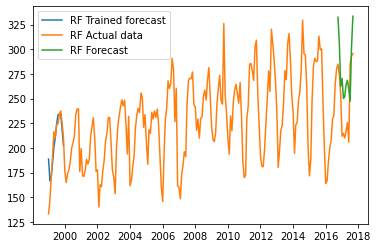

In [100]:
y_pred_train = svr.predict(x_train)
y_pred = svr.predict(x_test)

print("RF test RMSE: %.3f" % rmse(y_test, y_pred))

plt.plot(pd.Series(y_pred_train, index=x_train.index), label="RF Trained forecast")
plt.plot(y, label="RF Actual data")
plt.plot(pd.Series(y_pred, index=x_test.index), label="RF Forecast")
plt.legend();

#### We see that although the shape of the forecast is good, the height is a bit too high. Let's look what other methods like FBProphet & DL will bring to us, and then we will choose the best model.